# QUICKSTART: Classification sample

## Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from pwl.model.pwl import PWL

## Load dataset

In [2]:
feature, target = make_circles(n_samples=150, noise=0.2, factor=0.4, random_state=1)

scaler = StandardScaler()
scaler.fit(feature)

feature = scaler.transform(feature)

feature_tensor = torch.from_numpy(feature).float()
target_tensor = torch.from_numpy(target).long()

train_dataset = TensorDataset(feature_tensor, target_tensor)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Train model

In [3]:
model = PWL(input_dim=feature_tensor.shape[1], output_dim=target_tensor.max().item() + 1, num_layers=2, in_features=128, lr=5.0e-4)
trainer = pl.Trainer(max_epochs=200, gradient_clip_val=0.5)
trainer.fit(model, train_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | criterion     | NLLLoss    | 0     
1 | rho_unit      | Sequential | 642   
2 | output_linear | Sequential | 6     
---------------------------------------------
648       Trainable params
0         Non-trainable params
648       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


## Visualize

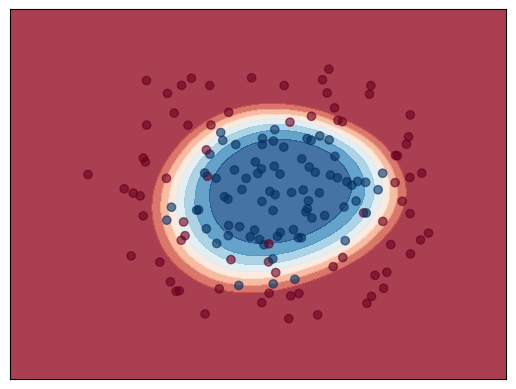

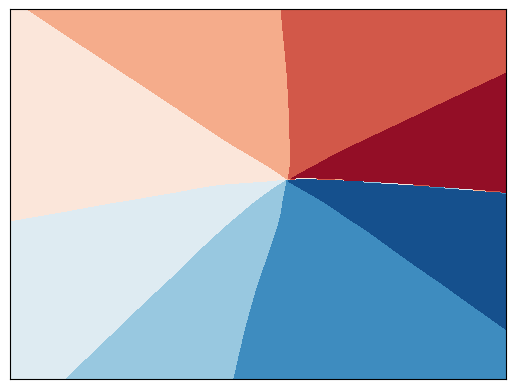

In [4]:
h = 0.02
x_min, x_max = feature[:, 0].min() - 1, feature[:, 0].max() + 1
y_min, y_max = feature[:, 1].min() - 1, feature[:, 1].max() + 1
X, Y = numpy.meshgrid(numpy.arange(x_min, x_max, h), numpy.arange(y_min, y_max, h))

feature_test = numpy.array((X.ravel(), Y.ravel())).T.reshape(X.size, feature.shape[1])
feature_test = torch.from_numpy(feature_test).float()

prob = model.predict_proba(feature_test).data.cpu().numpy()
Z = prob[:, 1].reshape(X.shape)

plt.ion()
plt.figure("Result")
plt.clf()
plt.contourf(X, Y, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.scatter(feature[:, 0], feature[:, 1], c=target, cmap=plt.cm.RdBu, alpha=0.6)
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.xticks(())
plt.yticks(())
plt.show()

weights = model.weights(feature_test).data.cpu().numpy()

u = weights[1, :, 0].reshape(X.shape)
v = weights[1, :, 1].reshape(X.shape)

plt.figure("Angle")
plt.clf()
plt.contourf(X, Y, numpy.arctan2(v, u), cmap=plt.cm.RdBu)
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.xticks(())
plt.yticks(())
plt.show()